In [1]:
import numpy as np
import time
from numba import jit, objmode
import matplotlib.pyplot as plt

## https://stackoverflow.com/questions/62131831/how-to-measure-time-in-numba-jit-function

In [2]:
## from https://github.com/XanaduAI/thewalrus/blob/master/thewalrus/_permanent.py
## use "np.searchsorted" instead of ".index"

@jit(nopython=True)
def perm_bbfg(M):  # pragma: no cover
    """
    Returns the permanent of a matrix using the bbfg formula in Gray ordering
    The code is a re-implementation from a Python 2 code found in
    `Permanent code golf
    `_
    using Numba.
    Args:
        M (array) : a square array.
    Returns:
        float or complex: the permanent of a matrix ``M``
    """

    n = len(M)
    if n == 0:
        return M.dtype.type(1.0)
    row_comb = np.sum(M, 0)
    total = 0
    old_gray = 0
    sign = +1
    binary_power_dict = np.array([2**i for i in range(n)])
    num_loops = 2 ** (n - 1)
    for bin_index in range(1, num_loops + 1):
        reduced = np.prod(row_comb)
        total += sign * reduced
        new_gray = bin_index ^ (bin_index // 2)
        gray_diff = old_gray ^ new_gray
        gray_diff_index = np.searchsorted(binary_power_dict,gray_diff)
        new_vector = M[gray_diff_index]
        direction = 2 * ((old_gray > new_gray) - (old_gray < new_gray))
        for i in range(n):
            row_comb[i] += new_vector[i] * direction
        sign = -sign
        old_gray = new_gray
    return total / num_loops

In [3]:
@jit(nopython=True)
def idx2site(Lx,Ly,idx):
    return np.vstack((idx%Lx,idx//Lx))

In [4]:
@jit(nopython=True)
def site2idx(Lx,Ly,x,y):
    return x+Lx*y

In [5]:
## open BC
@jit(nopython=True)
def makeSites(Lx,Ly):
    i1s = []
    i2s = []
    Js = []
    for y in range(Ly):
        for x in range(Lx):
            i0 = site2idx(Lx,Ly,x,y)
            if x+1<Lx:
                ix = site2idx(Lx,Ly,x+1,y)
                i1s.append(i0)
                i2s.append(ix)
                Js.append(-1.0)
            if y+1<Ly:
                iy = site2idx(Lx,Ly,x,y+1)
                i1s.append(i0)
                i2s.append(iy)
                Js.append(-1.0)
    i1s = np.array(i1s,dtype=np.int64)
    i2s = np.array(i2s,dtype=np.int64)
    Js = np.array(Js,dtype=np.float64)
    Nhbond = Js.shape[0]
    return i1s, i2s, Js, Nhbond

In [6]:
@jit(nopython=True)
def makeInitCDW(Lx,Ly):
    init_confs = np.zeros(Lx*Ly,dtype=np.int64)
    for y in range(Ly):
        for x in range(Lx):
            i0 = site2idx(Lx,Ly,x,y)
            init_confs[i0] = (1-(-1)**(x+y))//2
    num = np.sum(init_confs)
    init_is = np.zeros(num,dtype=np.int64)
    cnt = 0
    for i in range(Lx*Ly):
        if init_confs[i] == 1:
            init_is[cnt] = i
            cnt +=1
    return init_confs, init_is, num

In [7]:
@jit(nopython=True)
def makeHam(Ns,Nhbond,i1s,i2s,Js):
    Ham = np.zeros((Ns,Ns),dtype=np.float64)
    for i in range(Nhbond):
        Ham[i1s[i],i2s[i]] = Js[i]
        Ham[i2s[i],i1s[i]] = Js[i]
    return Ham

In [8]:
@jit(nopython=True)
def calcACDW(Ns,N_A,ene,vec,num,init_is,tstep):
#    y = vec.T @ (np.diag(np.exp(1j * ene * tstep))) @ vec
#    y = (vec.T).astype(np.complex128) @ (np.diag(np.exp(1j * ene * tstep))) @ vec.astype(np.complex128)
#    y = (vec.T).astype(np.complex128) @ (np.diag(np.exp(-1j * ene * tstep))) @ vec.astype(np.complex128)
    y = vec.astype(np.complex128) @ (np.diag(np.exp(-1j * ene * tstep))) @ (vec.T).astype(np.complex128)
    z = np.zeros((num,num),dtype=np.complex128)
    for j in range(num):
        ij = init_is[j]
        for k in range(num):
            ik = init_is[k]
            for m in range(N_A):
                z[j,k] += y[ij,m].conjugate() * y[ik,m]
    dlt = np.eye(num,dtype=np.complex128)
    matA = np.vstack( (np.hstack((z,dlt-z)), np.hstack((dlt-z,z))) )
    return matA

In [9]:
@jit(nopython=True)
def get_dat(Ns,N_A,ene,vec,num,init_is,nts,ts):
    data = np.zeros(nts,dtype=np.float64)
    for i in range(nts):
        tstep = ts[i]
        matA = calcACDW(Ns,N_A,ene,vec,num,init_is,tstep)
        data[i] = - np.log(perm_bbfg(matA).real)
    return data

In [10]:
#@jit(nopython=True)
def main():
    start = time.time()
#
    Lx = 2
    Ly = 2
    Ns = Lx*Ly
    N_A = Ns//2
    print("Lx",Lx)
    print("Ly",Ly)
    print("Ns",Ns)
    print("N_A",N_A)
#
    i1s, i2s, Js, Nhbond = makeSites(Lx,Ly)
    print("i1s",i1s)
    print("i2s",i2s)
    print("Js",Js)
    print("Nhbond",Nhbond,2*Lx*Ly-Lx-Ly) # true Nbond = Nhbond*2
#
    init_confs, init_is, num = makeInitCDW(Lx,Ly)
    print("init_confs",init_confs)
    print("init_is",init_is)
    print("num",num)
#
    Ham = makeHam(Ns,Nhbond,i1s,i2s,Js)
    print("Ham",Ham)
    ene, vec = np.linalg.eigh(Ham)
    print("ene",ene)
#    print("check ene[0]",vec[:,0].T@Ham@vec[:,0],ene[0])
#
    end = time.time()
    print("# time: before calculating time evolution",end-start)
#---- time evolution
    start = time.time()
    nts = 128+1
    ts = np.linspace(0,2*Ns,nts)
    data = get_dat(Ns,N_A,ene,vec,num,init_is,nts,ts)
    print("data",data)
    end = time.time()
#    print("# time: time evolution",end-start)
#---- plot fig
    plt.xlabel(r"time ")
    plt.ylabel(r"entropy ")
#    plt.xlim(np.min(ts),np.max(ts))
    plt.xlim(0,8)
    plt.ylim(np.min(data),np.max(data)*1.1)
    plt.plot(ts,data)
    plt.grid()
    plt.show()
    plt.close()
#
    plt.xlabel(r"time ")
    plt.ylabel(r"entropy ")
    plt.xlim(np.min(ts/Ns),np.max(ts/Ns))
    plt.ylim(np.min(data/Ns),np.max(data/Ns)*1.1)
    plt.plot(ts/Ns,data/Ns)
    plt.grid()
    plt.show()
    plt.close()

Lx 2
Ly 2
Ns 4
N_A 2
i1s [0 0 1 2]
i2s [1 2 3 3]
Js [-1. -1. -1. -1.]
Nhbond 4 4
init_confs [0 1 1 0]
init_is [1 2]
num 2
Ham [[ 0. -1. -1.  0.]
 [-1.  0.  0. -1.]
 [-1.  0.  0. -1.]
 [ 0. -1. -1.  0.]]
ene [-2.00000000e+00 -1.72985584e-16  1.24796029e-18  2.00000000e+00]
# time: before calculating time evolution 0.6041522026062012
data [3.55271368e-15 1.56045063e-02 6.21649054e-02 1.38866900e-01
 2.44164481e-01 3.75478997e-01 5.28753395e-01 6.97871407e-01
 8.74025204e-01 1.04526816e+00 1.19671392e+00 1.31199412e+00
 1.37631181e+00 1.38043264e+00 1.32373960e+00 1.21445221e+00
 1.06686143e+00 8.97335720e-01 7.21076077e-01 5.50451845e-01
 3.94670083e-01 2.60168694e-01 1.51242200e-01 7.06366180e-02
 2.00146702e-02 2.75309836e-04 1.17405801e-02 5.42253254e-02
 1.26996922e-01 2.28620797e-01 3.56677805e-01 5.07338024e-01
 6.74795353e-01 8.50632645e-01 1.02332854e+00 1.17833635e+00
 1.29934247e+00 1.37111727e+00 1.38346851e+00 1.33454936e+00
 1.23151277e+00 1.08807022e+00 9.20531932e-01 7.443

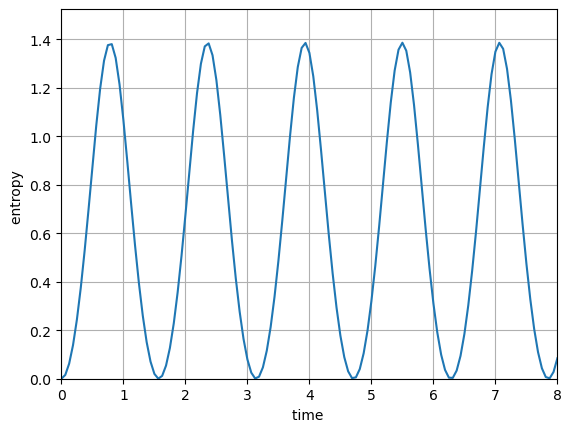

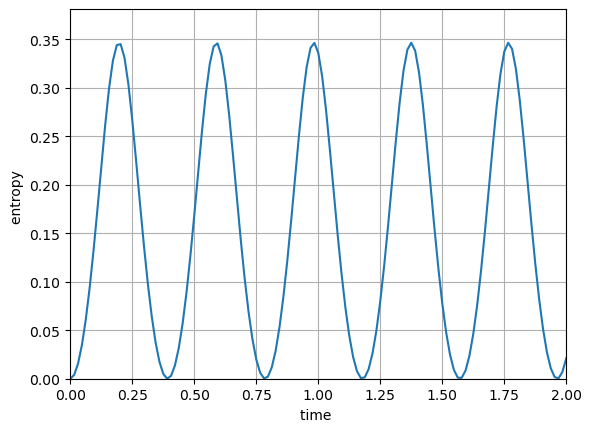

In [11]:
main()

In [12]:
#@jit(nopython=True)
def main():
    start = time.time()
#
    Lx = 4
    Ly = 4
    Ns = Lx*Ly
    N_A = Ns//2
    print("Lx",Lx)
    print("Ly",Ly)
    print("Ns",Ns)
    print("N_A",N_A)
#
    i1s, i2s, Js, Nhbond = makeSites(Lx,Ly)
    print("i1s",i1s)
    print("i2s",i2s)
    print("Js",Js)
    print("Nhbond",Nhbond,2*Lx*Ly-Lx-Ly) # true Nbond = Nhbond*2
#
    init_confs, init_is, num = makeInitCDW(Lx,Ly)
    print("init_confs",init_confs)
    print("init_is",init_is)
    print("num",num)
#
    Ham = makeHam(Ns,Nhbond,i1s,i2s,Js)
    print("Ham",Ham)
    ene, vec = np.linalg.eigh(Ham)
    print("ene",ene)
#    print("check ene[0]",vec[:,0].T@Ham@vec[:,0],ene[0])
#
    end = time.time()
    print("# time: before calculating time evolution",end-start)
#---- time evolution
    start = time.time()
    nts = 128+1
    ts = np.linspace(0,2*Ns,nts)
    data = get_dat(Ns,N_A,ene,vec,num,init_is,nts,ts)
    print("data",data)
    end = time.time()
#    print("# time: time evolution",end-start)
#---- plot fig
    plt.xlabel(r"time ")
    plt.ylabel(r"entropy ")
#    plt.xlim(np.min(ts),np.max(ts))
    plt.xlim(0,8)
    plt.ylim(np.min(data),np.max(data)*1.1)
    plt.plot(ts,data)
    plt.grid()
    plt.show()
    plt.close()
#
    plt.xlabel(r"time ")
    plt.ylabel(r"entropy ")
    plt.xlim(np.min(ts/Ns),np.max(ts/Ns))
    plt.ylim(np.min(data/Ns),np.max(data/Ns)*1.1)
    plt.plot(ts/Ns,data/Ns)
    plt.grid()
    plt.show()
    plt.close()

Lx 4
Ly 4
Ns 16
N_A 8
i1s [ 0  0  1  1  2  2  3  4  4  5  5  6  6  7  8  8  9  9 10 10 11 12 13 14]
i2s [ 1  4  2  5  3  6  7  5  8  6  9  7 10 11  9 12 10 13 11 14 15 13 14 15]
Js [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.]
Nhbond 24 24
init_confs [0 1 0 1 1 0 1 0 0 1 0 1 1 0 1 0]
init_is [ 1  3  4  6  9 11 12 14]
num 8
Ham [[ 0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  0. -1.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0. -1.  0. -1.  0.  0. -1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. -1.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.  0. -1.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  

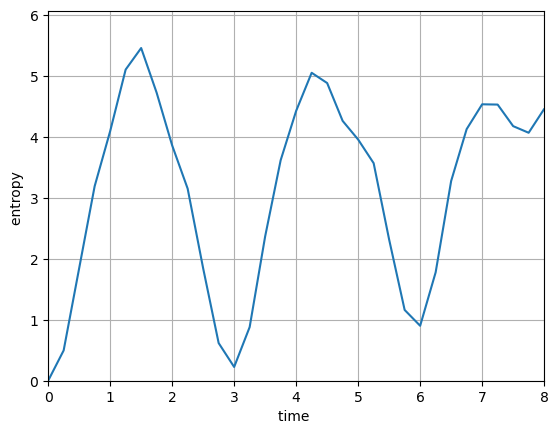

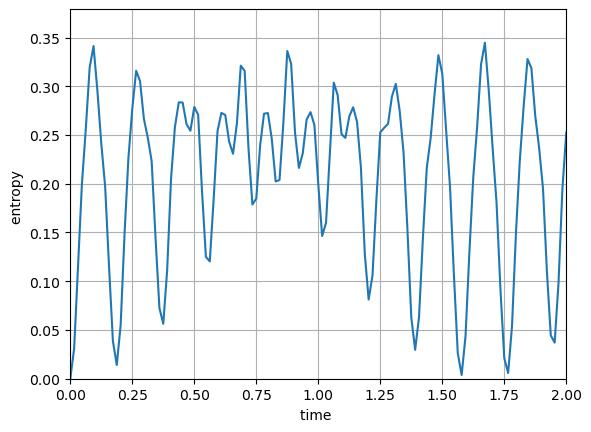

In [13]:
main()